<a target="_blank" href="https://colab.research.google.com/github/sonder-art/bandit_simulator/blob/main/bandit_sim.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import random
from typing import Tuple, List, Dict, Callable, Optional, Union
import time


In [ ]:
# Set seeds for reproducibility
np.random.seed(None)  # Use system entropy for true randomness
random.seed(None)  # Use system entropy for true randomness

In [ ]:
# ================ BANDIT ENVIRONMENT CLASSES ================

class BanditEnvironment:
    """Base class for bandit environments with 2 arms."""

    def __init__(self, T: int = 100):
        """
        Initialize the bandit environment.

        Args:
            T (int): Number of turns in the game
        """
        self.T = T
        self.current_turn = 0
        self.p1 = None  # Probability of arm 1 (visible)
        self.p2 = None  # Probability of arm 2 (hidden)
        self.history = {
            'actions': [],
            'rewards': [],
            'p1': [],
            'p2': []
        }

    def reset(self, T: Optional[int] = None) -> None:
        """
        Reset the environment for a new game.

        Args:
            T (int, optional): Number of turns for the new game
        """
        if T is not None:
            self.T = T
        self.current_turn = 0
        self.history = {
            'actions': [],
            'rewards': [],
            'p1': [],
            'p2': []
        }
        self._initialize_probabilities()

    def _initialize_probabilities(self) -> None:
        """Initialize the probabilities for both arms."""
        raise NotImplementedError("Subclasses must implement this method")

    def _update_probabilities(self) -> None:
        """Update the probabilities based on the current turn."""
        raise NotImplementedError("Subclasses must implement this method")

    def step(self, action: int) -> float:
        """
        Take a step in the environment by selecting an arm.

        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)

        Returns:
            float: The reward obtained
        """
        if self.current_turn >= self.T:
            raise ValueError("Game is over, please reset.")

        self._update_probabilities()

        # Record the current probabilities
        self.history['p1'].append(self.p1)
        self.history['p2'].append(self.p2)

        # Determine reward based on action
        if action == 0:  # Arm 1
            reward = 1.0 if np.random.random() < self.p1 else 0.0
        else:  # Arm 2
            reward = 1.0 if np.random.random() < self.p2 else 0.0

        # Update history
        self.history['actions'].append(action)
        self.history['rewards'].append(reward)

        # Increment turn
        self.current_turn += 1

        return reward

    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.

        Returns:
            Dict: Dictionary with visible information
        """
        return {
            'current_turn': self.current_turn,
            'total_turns': self.T,
            'p1': self.p1,
            'history': self.history
        }


class FixedBandit(BanditEnvironment):
    """Bandit with fixed probabilities throughout the game."""

    def _initialize_probabilities(self) -> None:
        """Initialize fixed probabilities for both arms."""
        self.p1 = np.random.uniform(0.01, 0.99)
        self.p2 = np.random.uniform(0.01, 0.99)

    def _update_probabilities(self) -> None:
        """No updates for fixed bandits."""
        pass


class PeriodicBandit(BanditEnvironment):
    """Bandit with probabilities that change every k turns."""

    def __init__(self, T: int = 100, k: int = 10):
        """
        Initialize the periodic bandit.

        Args:
            T (int): Number of turns
            k (int): Frequency of probability changes
        """
        super().__init__(T)
        self.k = k

    def _initialize_probabilities(self) -> None:
        """Initialize starting probabilities."""
        self.p1 = np.random.uniform(0.01, 0.99)
        self.p2 = np.random.uniform(0.01, 0.99)

    def _update_probabilities(self) -> None:
        """Update probabilities every k turns with completely new random values."""
        if self.current_turn % self.k == 0:
            self.p1 = np.random.uniform(0.01, 0.99)
            self.p2 = np.random.uniform(0.01, 0.99)


class DynamicBandit(BanditEnvironment):
    """Bandit with probabilities that change every turn."""

    def _initialize_probabilities(self) -> None:
        """Initialize starting probabilities."""
        self.p1 = np.random.uniform(0.01, 0.99)
        self.p2 = np.random.uniform(0.01, 0.99)

    def _update_probabilities(self) -> None:
        """Update probabilities every turn with completely new random values."""
        # Completely random new values
        self.p1 = np.random.uniform(0.01, 0.99)
        self.p2 = np.random.uniform(0.01, 0.99)


class FullyRandomBandit(BanditEnvironment):
    """Bandit where both arms are equally likely to be optimal, with random probabilities."""

    def _initialize_probabilities(self) -> None:
        """Initialize probabilities randomly for both arms."""
        self.p1 = np.random.uniform(0.01, 0.99)
        self.p2 = np.random.uniform(0.01, 0.99)

    def _update_probabilities(self) -> None:
        """
        Randomly reassign probabilities at certain turns to ensure
        no arm has a consistent advantage.
        """
        # Randomly reassign probabilities based on random chance
        if np.random.random() < 0.05:  # 5% chance per turn
            self.p1 = np.random.uniform(0.01, 0.99)
            self.p2 = np.random.uniform(0.01, 0.99)


# ================ EXPERIMENT RUNNER ================

def run_experiment(
    agent_func: Callable,
    n_games: int = 50,
    default_turns: int = 100,
    random_turns: bool = False,
    verbose: bool = True,
    env_type: str = "all"
) -> Dict:
    """
    Run an experiment with the given agent on all bandit environments.

    Args:
        agent_func (Callable): The agent function to use
        n_games (int): Number of games to play per environment
        default_turns (int): Default number of turns per game (used when random_turns=False)
        random_turns (bool): Whether to use random number of turns
        verbose (bool): Whether to show progress bar
        env_type (str): Type of environment to use ("all" or specific type)

    Returns:
        Dict: Results of the experiment
    """
    # Force different random seed each time
    current_time = time.time()
    np.random.seed(int(current_time * 1000) % 10000)
    random.seed(int(current_time * 2000) % 10000)

    # Debug output
    if random_turns:
        print("RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game")
        # Show some sample random turn values
        samples = [np.random.randint(1, 301) for _ in range(5)]
        print(f"Sample turn counts: {samples}")
    else:
        print(f"FIXED TURNS MODE: Using T={default_turns} for all games")

    all_environments = {
        "Fixed": FixedBandit(),
        "Periodic": PeriodicBandit(k=10),
        "Dynamic": DynamicBandit(),
        "FullyRandom": FullyRandomBandit()
    }

    # If a specific environment type is requested, use only that one
    if env_type != "all" and env_type in all_environments:
        environments = [all_environments[env_type]]
        environment_names = [env_type]
    else:
        # Otherwise use all environments
        environments = list(all_environments.values())
        environment_names = list(all_environments.keys())

    results = {
        "environment": [],
        "game": [],
        "total_reward": [],
        "average_reward": [],
        "turns": [],
        "actions": [],
        "optimal_actions": [],
        "regret": []
    }

    # Create turn counts in advance for reproducibility and debugging
    all_turn_counts = []
    if random_turns:
        for _ in range(n_games * len(environments)):
            # Generate a truly random T between 1 and 300
            all_turn_counts.append(np.random.randint(1, 301))
    else:
        all_turn_counts = [default_turns] * (n_games * len(environments))

    # Use tqdm for progress if verbose
    game_iterator = tqdm(range(n_games * len(environments))) if verbose else range(n_games * len(environments))

    for game_idx in game_iterator:
        env_idx = game_idx // n_games
        game_num = game_idx % n_games

        env = environments[env_idx]

        # Get pre-generated turn count for this game
        T = all_turn_counts[game_idx]

        # Debug output
        if verbose and game_idx % 20 == 0:
            print(f"Game {game_idx}, Environment: {environment_names[env_idx]}, Turn count: {T}")

        env.reset(T)

        total_reward = 0
        optimal_actions = 0

        # Start the game
        for _ in range(T):
            # Prepare the visible info for the agent based on agent type
            if agent_func == full_information_agent:
                visible_info = env.get_visible_info()
            elif agent_func == partial_information_agent:
                visible_info = {
                    'current_turn': env.current_turn,
                    'total_turns': env.T,
                    'p1': env.p1,
                    'history': {
                        'actions': env.history['actions'],
                        'rewards': env.history['rewards']
                    }
                }
            else:  # reward_only_agent
                visible_info = {
                    'current_turn': env.current_turn,
                    'history': {
                        'actions': env.history['actions'],
                        'rewards': env.history['rewards']
                    }
                }

            # Get action from agent
            action = agent_func(visible_info)

            # Take step in environment
            reward = env.step(action)
            total_reward += reward

            # Count optimal actions (choosing the arm with highest probability)
            if (action == 0 and env.p1 >= env.p2) or (action == 1 and env.p2 > env.p1):
                optimal_actions += 1

        # Calculate regret (difference between optimal and actual rewards)
        optimal_expected_reward = sum(max(p1, p2) for p1, p2 in zip(env.history['p1'], env.history['p2']))
        actual_expected_reward = sum(
            env.history['p1'][i] if action == 0 else env.history['p2'][i]
            for i, action in enumerate(env.history['actions'])
        )
        regret = optimal_expected_reward - actual_expected_reward

        # Store results
        results["environment"].append(environment_names[env_idx])
        results["game"].append(game_num)
        results["total_reward"].append(total_reward)
        results["average_reward"].append(total_reward / T)
        results["turns"].append(T)
        results["actions"].append(env.history['actions'])
        results["optimal_actions"].append(optimal_actions / T * 100)  # percentage
        results["regret"].append(regret)

    # Verify turn counts are as expected
    if random_turns:
        turn_counts = np.array(results["turns"])
        print(f"\nTurn count summary: Min={turn_counts.min()}, Max={turn_counts.max()}, Mean={turn_counts.mean():.2f}")
        if turn_counts.min() == turn_counts.max():
            print("WARNING: All turn counts are the same! Random turns mode may not be working correctly.")

    return results


# ================ STANDARDIZED EXPERIMENT RUNNER ================

def run_standard_experiment(agent_func: Callable, env_type: str, n_experiments: int = 100, fixed_turns: bool = True) -> Dict:
    """
    Run a standardized experiment for a specific agent on a specific environment.

    Args:
        agent_func (Callable): The agent function to use
        env_type (str): Type of environment to use
        n_experiments (int): Number of experiments to run (default 100)
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)

    Returns:
        Dict: Results of the experiment
    """
    # Force different random seed for this experiment
    current_time = time.time()
    np.random.seed(int(current_time * 1000) % 10000)
    random.seed(int(current_time * 2000) % 10000)

    if fixed_turns:
        print("\n=== RUNNING WITH FIXED TURNS (T=100) ===")
        default_turns = 100
        random_turns = False
    else:
        print("\n=== RUNNING WITH RANDOM TURNS (T=1-300) ===")
        default_turns = 100  # This value is only used if random_turns is False
        random_turns = True

        # Show some sample turn values to verify randomness
        samples = [np.random.randint(1, 301) for _ in range(5)]
        print(f"Sample random turn values: {samples}")

    # Run the experiment
    return run_experiment(
        agent_func=agent_func,
        n_games=n_experiments,
        default_turns=default_turns,
        random_turns=random_turns,
        verbose=True,
        env_type=env_type
    )


# ================ VISUALIZATION FUNCTIONS ================

def plot_rewards_by_environment(results: Dict) -> None:
    """
    Plot average rewards for each environment.

    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Average Reward': results['average_reward']
    })

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Average Reward', data=df)
    plt.title('Distribution of Average Rewards by Environment')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_optimal_actions(results: Dict) -> None:
    """
    Plot percentage of optimal actions for each environment.

    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Optimal Actions (%)': results['optimal_actions']
    })

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Optimal Actions (%)', data=df)
    plt.title('Percentage of Optimal Actions by Environment')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_regret(results: Dict) -> None:
    """
    Plot regret for each environment.

    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Regret': results['regret']
    })

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Regret', data=df)
    plt.title('Distribution of Regret by Environment')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_action_history(results: Dict, game_idx: int) -> None:
    """
    Plot action history for a specific game.

    Args:
        results (Dict): Results from run_experiment
        game_idx (int): Index of the game to plot
    """
    env_name = results['environment'][game_idx]
    actions = results['actions'][game_idx]

    plt.figure(figsize=(12, 4))
    plt.plot(actions, 'o-', markersize=4)
    plt.yticks([0, 1], ['Arm 1', 'Arm 2'])
    plt.title(f'Action History for {env_name} Environment - Game {results["game"][game_idx]}')
    plt.xlabel('Turn')
    plt.ylabel('Action')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_reward_over_time(results: Dict, n_games: int = 5) -> None:
    """
    Plot cumulative reward over time for selected games.

    Args:
        results (Dict): Results from run_experiment
        n_games (int): Number of games to plot per environment
    """
    # Select game indices to plot
    env_names = list(set(results['environment']))

    plt.figure(figsize=(15, 8))

    for env_name in env_names:
        env_game_indices = [i for i, e in enumerate(results['environment']) if e == env_name]

        # Select a subset of games for this environment
        selected_indices = env_game_indices[:n_games]

        for idx in selected_indices:
            actions = results['actions'][idx]
            turns = results['turns'][idx]

            # Reconstruct cumulative rewards
            cum_rewards = np.cumsum([results['total_reward'][idx] / turns] * turns)

            plt.plot(cum_rewards, alpha=0.7, label=f"{env_name} - Game {results['game'][idx]}")

    plt.title('Cumulative Reward Over Time')
    plt.xlabel('Turn')
    plt.ylabel('Cumulative Reward')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.show()


def generate_statistical_summary(results: Dict) -> pd.DataFrame:
    """
    Generate a comprehensive statistical summary from experiment results.

    Args:
        results (Dict): Results from run_experiment

    Returns:
        pd.DataFrame: Statistical summary
    """
    # Convert results to DataFrame
    data = []
    for i in range(len(results['environment'])):
        data.append({
            'Environment': results['environment'][i],
            'Game': results['game'][i],
            'Total Reward': results['total_reward'][i],
            'Average Reward': results['average_reward'][i],
            'Turns': results['turns'][i],
            'Optimal Actions (%)': results['optimal_actions'][i],
            'Regret': results['regret'][i]
        })

    df = pd.DataFrame(data)

    # Group by environment and calculate statistics
    summary = df.groupby('Environment').agg({
        'Total Reward': ['mean', 'std', 'min', 'max'],
        'Average Reward': ['mean', 'std', 'min', 'max'],
        'Optimal Actions (%)': ['mean', 'std', 'min', 'max'],
        'Regret': ['mean', 'std', 'min', 'max'],
        'Turns': ['mean', 'count']
    })

    # Rename the columns for better readability
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

    return summary


def plot_performance_metrics(results: Dict, title_prefix: str = "") -> None:
    """
    Plot comprehensive performance metrics for the agent.

    Args:
        results (Dict): Results from run_experiment
        title_prefix (str): Prefix for plot titles
    """
    # Convert results to DataFrame
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Average Reward': results['average_reward'],
        'Optimal Actions (%)': results['optimal_actions'],
        'Regret': results['regret'],
        'Turns': results['turns']
    })

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot average reward
    sns.boxplot(x='Environment', y='Average Reward', data=df, ax=axes[0, 0])
    axes[0, 0].set_title(f'{title_prefix}Average Reward by Environment')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot optimal action percentage
    sns.boxplot(x='Environment', y='Optimal Actions (%)', data=df, ax=axes[0, 1])
    axes[0, 1].set_title(f'{title_prefix}Optimal Actions (%) by Environment')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot regret
    sns.boxplot(x='Environment', y='Regret', data=df, ax=axes[1, 0])
    axes[1, 0].set_title(f'{title_prefix}Regret by Environment')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot learning curve for each environment (using first few games)
    for env_name in set(df['Environment']):
        env_df = df[df['Environment'] == env_name]

        # Select a random game for this environment
        selected_game = env_df.iloc[0]['Game']

        # Find the index in the original results
        game_idx = next(i for i, (e, g) in enumerate(zip(results['environment'], results['game']))
                         if e == env_name and g == selected_game)

        actions = results['actions'][game_idx]
        turns = results['turns'][game_idx]

        # Plot action history
        axes[1, 1].plot(range(turns), actions, 'o-', markersize=3, label=env_name, alpha=0.7)

    axes[1, 1].set_title(f'{title_prefix}Action History by Environment')
    axes[1, 1].set_xlabel('Turn')
    axes[1, 1].set_ylabel('Action')
    axes[1, 1].set_yticks([0, 1])
    axes[1, 1].set_yticklabels(['Arm 1', 'Arm 2'])
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()


def visualize_simplified_results(results: Dict, agent_name: str = "Agent") -> None:
    """
    Simplified visualization showing only aggregate results across all games.

    Args:
        results (Dict): Results from run_experiment
        agent_name (str): Name of the agent for titles
    """
    # Convert results to DataFrame
    data = []
    for i in range(len(results['environment'])):
        data.append({
            'Environment': results['environment'][i],
            'Game': results['game'][i],
            'Average Reward': results['average_reward'][i],
            'Optimal Actions (%)': results['optimal_actions'][i],
            'Regret': results['regret'][i],
            'Turns': results['turns'][i]
        })

    df = pd.DataFrame(data)

    # Generate and display statistical summary
    summary = df.groupby('Environment').agg({
        'Average Reward': ['mean', 'std', 'min', 'max'],
        'Optimal Actions (%)': ['mean', 'std', 'min', 'max'],
        'Regret': ['mean', 'std'],
        'Turns': ['mean', 'std', 'min', 'max', 'count']
    })

    # Rename the columns for better readability
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

    # Print agent name and summary statistics
    print(f"\n===== {agent_name} Summary Statistics =====\n")
    summary_display = summary.round(3)  # Round to 3 decimal places for cleaner display
    print(summary_display)

    # Print the turn count distribution to verify random generation is working
    if "Random" in agent_name:
        print("\nTurn Count Distribution:")
        turn_counts = df.groupby('Turns').size().reset_index(name='Count')
        turn_summary = f"Min: {df['Turns'].min()}, Max: {df['Turns'].max()}, Mean: {df['Turns'].mean():.2f}, Std: {df['Turns'].std():.2f}"
        print(turn_summary)

        # Plot turn count histogram
        plt.figure(figsize=(10, 4))
        plt.hist(df['Turns'], bins=30, alpha=0.7)
        plt.title('Turn Count Distribution')
        plt.xlabel('Number of Turns')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Create a figure with key metrics
    plt.figure(figsize=(15, 10))

    # Average Reward
    plt.subplot(2, 2, 1)
    sns.barplot(x='Environment', y='Average Reward', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Average Reward by Environment')
    plt.grid(True, alpha=0.3)

    # Optimal Actions
    plt.subplot(2, 2, 2)
    sns.barplot(x='Environment', y='Optimal Actions (%)', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Optimal Actions (%) by Environment')
    plt.grid(True, alpha=0.3)

    # Regret
    plt.subplot(2, 2, 3)
    sns.barplot(x='Environment', y='Regret', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Regret by Environment')
    plt.grid(True, alpha=0.3)

    # Reward distribution
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Environment', y='Average Reward', data=df)
    plt.title(f'Reward Distribution by Environment')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f"{agent_name} Performance Across Environments", fontsize=16, y=1.02)
    plt.show()

    # Show reward distributions as violin plots
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Environment', y='Average Reward', data=df)
    plt.title(f'{agent_name}: Reward Distribution by Environment')
    plt.grid(True, alpha=0.3)
    plt.show()


def visualize_results(results: Dict) -> None:
    """
    Visualize the results of the experiment.

    Args:
        results (Dict): Results from run_experiment
    """
    # Convert results to pandas DataFrame for easier analysis
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Total Reward': results['total_reward'],
        'Average Reward': results['average_reward'],
        'Turns': results['turns'],
        'Optimal Actions (%)': results['optimal_actions'],
        'Regret': results['regret']
    })

    # Summary statistics by environment
    summary = df.groupby('Environment').agg({
        'Total Reward': ['mean', 'std'],
        'Average Reward': ['mean', 'std'],
        'Optimal Actions (%)': ['mean', 'std'],
        'Regret': ['mean', 'std']
    })

    print("===== Summary Statistics =====")
    print(summary)
    print("\n")

    # Plot visualizations
    plot_rewards_by_environment(results)
    plot_optimal_actions(results)
    plot_regret(results)

    # Plot action history for the first game of each environment
    for env_name in ['Fixed', 'Periodic', 'Dynamic']:
        game_idx = results['environment'].index(env_name)
        plot_action_history(results, game_idx)

    # Plot reward over time for a subset of games
    plot_reward_over_time(results, n_games=2)


# ================ INDIVIDUAL AGENT EVALUATION FUNCTIONS ================

def evaluate_full_information_agent(fixed_turns: bool = True) -> Dict:
    """
    Run standardized evaluation for just the full information agent.

    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)

    Returns:
        Dict: Results for the full information agent
    """
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    print(f"===== EVALUATING FULL INFORMATION AGENT WITH {turns_type} TURNS =====")

    # Dictionary to store results for each environment
    results = {}
    all_results = {}

    # Test on each environment type
    env_types = ["Fixed", "Periodic", "Dynamic", "FullyRandom"]
    for env_type in env_types:
        print(f"\nTesting on {env_type} environment...")

        # Run the experiment with specified turns type
        env_results = run_standard_experiment(
            agent_func=full_information_agent,
            env_type=env_type,
            fixed_turns=fixed_turns
        )

        # Store results
        results[env_type] = env_results
        all_results.update({env_type: env_results})

    # Display aggregate results for all environments together
    print(f"\n===== FULL INFORMATION AGENT SUMMARY ({turns_type} TURNS) =====")

    # Combine all environment results
    combined_results = {
        "environment": [],
        "game": [],
        "total_reward": [],
        "average_reward": [],
        "turns": [],
        "actions": [],
        "optimal_actions": [],
        "regret": []
    }

    for env_results in results.values():
        for key in combined_results.keys():
            combined_results[key].extend(env_results[key])

    # Visualize the combined results
    agent_name = f"Full Information Agent ({turns_type})"
    visualize_simplified_results(combined_results, agent_name=agent_name)

    return all_results


def evaluate_partial_information_agent(fixed_turns: bool = True) -> Dict:
    """
    Run standardized evaluation for just the partial information agent.

    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)

    Returns:
        Dict: Results for the partial information agent
    """
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    print(f"===== EVALUATING PARTIAL INFORMATION AGENT WITH {turns_type} TURNS =====")

    # Dictionary to store results for each environment
    results = {}
    all_results = {}

    # Test on each environment type
    env_types = ["Fixed", "Periodic", "Dynamic", "FullyRandom"]
    for env_type in env_types:
        print(f"\nTesting on {env_type} environment...")

        # Run the experiment with specified turns type
        env_results = run_standard_experiment(
            agent_func=partial_information_agent,
            env_type=env_type,
            fixed_turns=fixed_turns
        )

        # Store results
        results[env_type] = env_results
        all_results.update({env_type: env_results})

    # Display aggregate results for all environments together
    print(f"\n===== PARTIAL INFORMATION AGENT SUMMARY ({turns_type} TURNS) =====")

    # Combine all environment results
    combined_results = {
        "environment": [],
        "game": [],
        "total_reward": [],
        "average_reward": [],
        "turns": [],
        "actions": [],
        "optimal_actions": [],
        "regret": []
    }

    for env_results in results.values():
        for key in combined_results.keys():
            combined_results[key].extend(env_results[key])

    # Visualize the combined results
    agent_name = f"Partial Information Agent ({turns_type})"
    visualize_simplified_results(combined_results, agent_name=agent_name)

    return all_results


def evaluate_reward_only_agent(fixed_turns: bool = True) -> Dict:
    """
    Run standardized evaluation for just the reward-only agent.

    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)

    Returns:
        Dict: Results for the reward-only agent
    """
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    print(f"===== EVALUATING REWARD-ONLY AGENT WITH {turns_type} TURNS =====")

    # Dictionary to store results for each environment
    results = {}
    all_results = {}

    # Test on each environment type
    env_types = ["Fixed", "Periodic", "Dynamic", "FullyRandom"]
    for env_type in env_types:
        print(f"\nTesting on {env_type} environment...")

        # Run the experiment with specified turns type
        env_results = run_standard_experiment(
            agent_func=reward_only_agent,
            env_type=env_type,
            fixed_turns=fixed_turns
        )

        # Store results
        results[env_type] = env_results
        all_results.update({env_type: env_results})

    # Display aggregate results for all environments together
    print(f"\n===== REWARD-ONLY AGENT SUMMARY ({turns_type} TURNS) =====")

    # Combine all environment results
    combined_results = {
        "environment": [],
        "game": [],
        "total_reward": [],
        "average_reward": [],
        "turns": [],
        "actions": [],
        "optimal_actions": [],
        "regret": []
    }

    for env_results in results.values():
        for key in combined_results.keys():
            combined_results[key].extend(env_results[key])

    # Visualize the combined results
    agent_name = f"Reward-Only Agent ({turns_type})"
    visualize_simplified_results(combined_results, agent_name=agent_name)

    return all_results


def evaluate_agent(agent_func: Callable, agent_name: str) -> Dict:
    """
    Comprehensively evaluate an agent across all environment types.

    Args:
        agent_func (Callable): The agent function to evaluate
        agent_name (str): Name of the agent for reporting

    Returns:
        Dict: Results for all environments
    """
    print(f"===== Evaluating {agent_name} =====")

    # Dictionary to store results for each environment
    all_env_results = {}

    # Test on each environment type
    env_types = ["Fixed", "Periodic", "Dynamic", "FullyRandom"]
    for env_type in env_types:
        print(f"\nTesting on {env_type} environment...")

        # Fixed turns (T=100) for environments where T is known
        results = run_standard_experiment(
            agent_func=agent_func,
            env_type=env_type,
            fixed_turns=True  # Use T=100
        )

        all_env_results[env_type] = results

    # If this is the reward-only agent, also test with unknown T
    if agent_func == reward_only_agent:
        print("\nTesting reward-only agent with unknown number of turns...")

        for env_type in env_types:
            random_results = run_standard_experiment(
                agent_func=agent_func,
                env_type=env_type,
                fixed_turns=False  # Random T between 1-300
            )
            all_env_results[f"{env_type}_random_T"] = random_results

    return all_env_results


def run_all_agents() -> Dict:
    """
    Run standard evaluations for all agent types.

    Returns:
        Dict: Comprehensive results for all agents
    """
    print("======= RUNNING COMPREHENSIVE AGENT EVALUATION =======")

    results = {}

    # Evaluate each agent type
    results["full_information"] = evaluate_agent(full_information_agent, "Full Information Agent")
    results["partial_information"] = evaluate_agent(partial_information_agent, "Partial Information Agent")
    results["reward_only"] = evaluate_agent(reward_only_agent, "Reward-Only Agent")

    # Compare agents
    print("\n======= AGENT COMPARISON =======")
    compare_all_agents(results)

    return results


def compare_all_agents(all_results: Dict) -> None:
    """
    Compare the performance of all agents across environments.

    Args:
        all_results (Dict): Results from run_all_agents
    """
    # Prepare data for comparison
    comparison_data = []

    # Collect results from each agent and environment
    for agent_name, agent_results in all_results.items():
        for env_name, results in agent_results.items():
            # Skip random T results for cleaner comparison
            if "_random_T" in env_name:
                continue

            # Calculate mean performance metrics for this agent in this environment
            df = pd.DataFrame({
                'Environment': results['environment'],
                'Average Reward': results['average_reward'],
                'Optimal Actions (%)': results['optimal_actions'],
                'Regret': results['regret']
            })

            # Get mean values
            mean_reward = df['Average Reward'].mean()
            mean_optimal = df['Optimal Actions (%)'].mean()
            mean_regret = df['Regret'].mean()

            # Add to comparison data
            comparison_data.append({
                'Agent': agent_name.replace('_', ' ').title(),
                'Environment': env_name,
                'Average Reward': mean_reward,
                'Optimal Actions (%)': mean_optimal,
                'Regret': mean_regret
            })

    # Convert to DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    # Display comprehensive summary table (rounded to 3 decimal places for readability)
    print("\n===== AGENT COMPARISON SUMMARY =====")
    print("\nPerformance Metrics by Agent and Environment:")
    display_df = comparison_df.round(3)
    print(display_df)

    # Create comparison plots
    plt.figure(figsize=(15, 10))

    # Average Reward
    plt.subplot(2, 2, 1)
    sns.barplot(x='Environment', y='Average Reward', hue='Agent', data=comparison_df, errorbar=('ci', 95))
    plt.title('Average Reward by Agent and Environment')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Optimal Actions
    plt.subplot(2, 2, 2)
    sns.barplot(x='Environment', y='Optimal Actions (%)', hue='Agent', data=comparison_df, errorbar=('ci', 95))
    plt.title('Optimal Actions (%) by Agent and Environment')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Regret
    plt.subplot(2, 2, 3)
    sns.barplot(x='Environment', y='Regret', hue='Agent', data=comparison_df, errorbar=('ci', 95))
    plt.title('Regret by Agent and Environment')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Generate heatmap for average reward
    plt.subplot(2, 2, 4)
    reward_pivot = comparison_df.pivot_table(
        index='Agent',
        columns='Environment',
        values='Average Reward'
    )
    sns.heatmap(reward_pivot, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Average Reward Heatmap')

    plt.tight_layout()
    plt.suptitle("Agent Performance Comparison", fontsize=16, y=1.02)
    plt.show()

    # Generate summary of best agent for each environment
    print("\nBest Agent for Each Environment (Based on Average Reward):")
    best_agents = comparison_df.loc[comparison_df.groupby('Environment')['Average Reward'].idxmax()]
    print(best_agents[['Environment', 'Agent', 'Average Reward']].round(3))

    # Generate summary of best environment for each agent
    print("\nBest Environment for Each Agent (Based on Average Reward):")
    best_envs = comparison_df.loc[comparison_df.groupby('Agent')['Average Reward'].idxmax()]
    print(best_envs[['Agent', 'Environment', 'Average Reward']].round(3))

    # Create simple ranking table based on average reward across all environments
    print("\nOverall Agent Ranking (Based on Average Reward Across All Environments):")
    agent_ranking = comparison_df.groupby('Agent')['Average Reward'].mean().reset_index()
    agent_ranking = agent_ranking.sort_values('Average Reward', ascending=False)
    print(agent_ranking.round(3))




# Example usage for students
"""
# STUDENTS: Implement your solutions for the agent functions above.
# Then run the evaluations to test your implementations.

# To evaluate just one agent type at a time (for optimization):
# With fixed turns (T=100)
full_info_results = evaluate_full_information_agent(fixed_turns=True)
# OR
partial_info_results = evaluate_partial_information_agent(fixed_turns=True)
# OR
reward_only_results = evaluate_reward_only_agent(fixed_turns=True)

# With random turns (T=1-300)
full_info_random_results = evaluate_full_information_agent(fixed_turns=False)
# OR
partial_info_random_results = evaluate_partial_information_agent(fixed_turns=False)
# OR
reward_only_random_results = evaluate_reward_only_agent(fixed_turns=False)

# To run comprehensive evaluation of all agents:
# With fixed turns (T=100)
all_results = run_all_agents(fixed_turns=True)
# With random turns (T=1-300)
all_random_results = run_all_agents(fixed_turns=False)
"""

'\n# STUDENTS: Implement your solutions for the agent functions above.\n# Then run the evaluations to test your implementations.\n\n# To evaluate just one agent type at a time (for optimization):\n# With fixed turns (T=100)\nfull_info_results = evaluate_full_information_agent(fixed_turns=True)\n# OR\npartial_info_results = evaluate_partial_information_agent(fixed_turns=True)\n# OR\nreward_only_results = evaluate_reward_only_agent(fixed_turns=True)\n\n# With random turns (T=1-300)\nfull_info_random_results = evaluate_full_information_agent(fixed_turns=False)\n# OR\npartial_info_random_results = evaluate_partial_information_agent(fixed_turns=False)\n# OR\nreward_only_random_results = evaluate_reward_only_agent(fixed_turns=False)\n\n# To run comprehensive evaluation of all agents:\n# With fixed turns (T=100)\nall_results = run_all_agents(fixed_turns=True)\n# With random turns (T=1-300)\nall_random_results = run_all_agents(fixed_turns=False)\n'

# Agentes para Definir

## Informacion Completa

In [ ]:
import numpy as np
from typing import Dict

def full_information_agent(env_info: Dict) -> int:
    """
    Agent that follows an optimal exploration-exploitation strategy.

    Args:
        env_info (Dict): Dictionary containing:
            - current_turn: Current turn number
            - total_turns: Total number of turns
            - p1: Probability of arm 1
            - history: Dictionary with past actions, rewards, and visible probabilities

    Returns:
        int: The action to take (0 for arm 1, 1 for arm 2)
    """
    current_turn = env_info["current_turn"]
    total_turns = env_info["total_turns"]
    p1 = env_info["p1"]
    history = env_info["history"]

    # Fase de exploración: los primeros sqrt(T) turnos juegan solo con p2
    n_exploration = int(np.sqrt(total_turns))

    if current_turn < n_exploration:
        return 1  # Jugar p2 en fase de exploración

    # Fase de explotación: calcular la media empírica de p2
    rewards_p2 = [
        history["rewards"][i]
        for i in range(len(history["actions"]))
        if history["actions"][i] == 1
    ]

    if rewards_p2:
        mean_p2 = np.mean(rewards_p2)
    else:
        mean_p2 = 0  # Si no hay datos de p2, asumir 0 (extremo conservador)

    # Elegir el brazo con mayor recompensa esperada
    if mean_p2 > p1:
        return 1  # Seguir con p2
    else:
        return 0  # Cambiar a p1

In [1]:
full_info_results = evaluate_full_information_agent()


NameError: name 'evaluate_full_information_agent' is not defined

===== EVALUATING FULL INFORMATION AGENT WITH Random (T=1-300) TURNS =====

Testing on Fixed environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [180, 291, 21, 195, 122]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [180, 291, 21, 195, 122]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Fixed, Turn count: 54
Game 20, Environment: Fixed, Turn count: 123
Game 40, Environment: Fixed, Turn count: 59
Game 60, Environment: Fixed, Turn count: 64
Game 80, Environment: Fixed, Turn count: 117

Turn count summary: Min=3, Max=300, Mean=151.67

Testing on Periodic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [26, 267, 151, 107, 262]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [26, 267, 151, 107, 262]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Periodic, Turn count: 208
Game 20, Environment: Periodic, Turn count: 32
Game 40, Environment: Periodic, Turn count: 50
Game 60, Environment: Periodic, Turn count: 55
Game 80, Environment: Periodic, Turn count: 15

Turn count summary: Min=2, Max=297, Mean=137.84

Testing on Dynamic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [184, 140, 200, 186, 278]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [184, 140, 200, 186, 278]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Dynamic, Turn count: 169
Game 20, Environment: Dynamic, Turn count: 285
Game 40, Environment: Dynamic, Turn count: 202
Game 60, Environment: Dynamic, Turn count: 143
Game 80, Environment: Dynamic, Turn count: 56

Turn count summary: Min=1, Max=291, Mean=136.08

Testing on FullyRandom environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [242, 194, 192, 22, 34]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [242, 194, 192, 22, 34]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: FullyRandom, Turn count: 27
Game 20, Environment: FullyRandom, Turn count: 286
Game 40, Environment: FullyRandom, Turn count: 32
Game 60, Environment: FullyRandom, Turn count: 181
Game 80, Environment: FullyRandom, Turn count: 61

Turn count summary: Min=5, Max=300, Mean=144.33

===== FULL INFORMATION AGENT SUMMARY (Random (T=1-300) TURNS) =====

===== Full Information Agent (Random (T=1-300)) Summary Statistics =====

             Average Reward_mean  Average Reward_std  Average Reward_min  \
Environment                                                                
Dynamic                    0.502               0.073               0.000   
Fixed                      0.489               0.191               0.128   
FullyRandom                0.502               0.109               0.234   
Periodic                   0.511               0.130               0.067   

             Average Reward_max  Optimal Actions (%)_mean  \
Environment                           

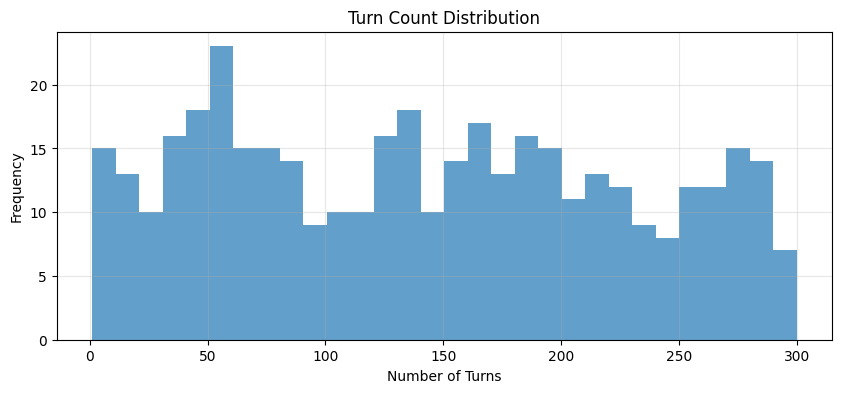

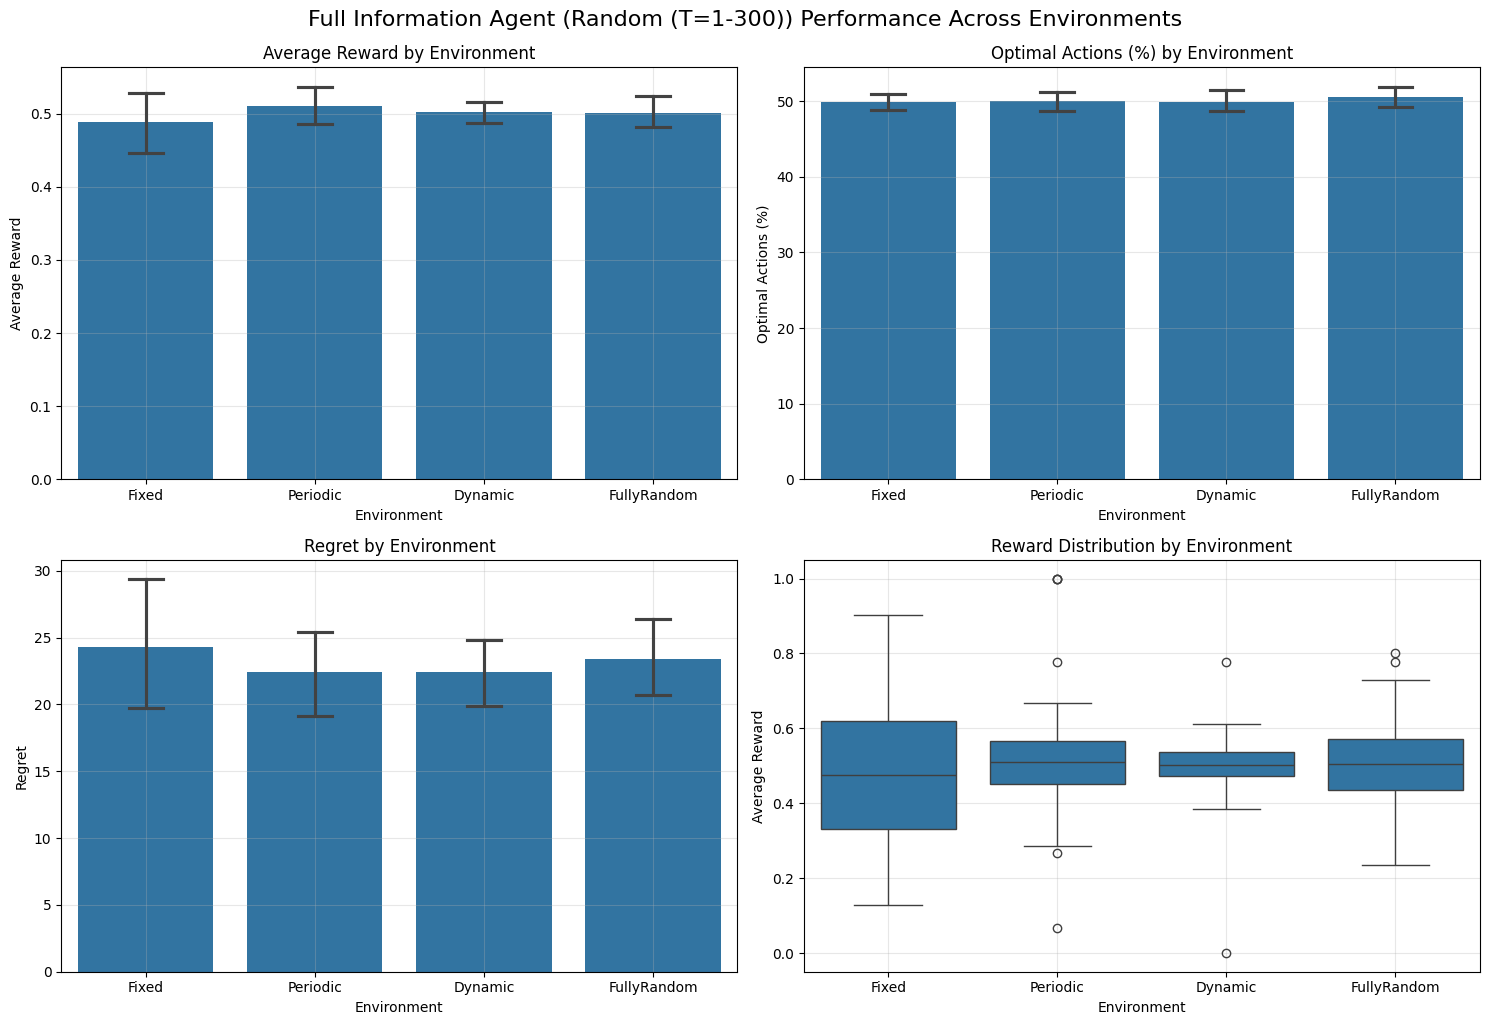

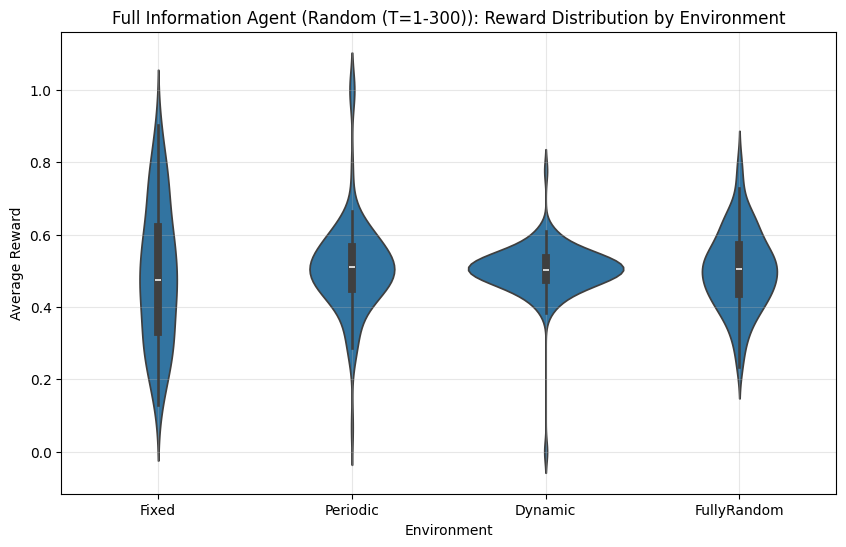

In [ ]:
full_info_results = evaluate_full_information_agent(fixed_turns=False)


#

## Informacion Parcial

In [2]:
import numpy as np
from typing import Dict

def partial_information_agent(env_info: Dict) -> int:
    """
    Agent that follows an exploration-exploitation strategy using UCB for the hidden arm.

    Args:
        env_info (Dict): Dictionary containing:
            - current_turn: Current turn number
            - total_turns: Total number of turns
            - p1: Probability of arm 1
            - history: Dictionary with past actions and rewards

    Returns:
        int: The action to take (0 for arm 1, 1 for arm 2)
    """
    current_turn = env_info["current_turn"]
    p1 = env_info["p1"]
    history = env_info["history"]

    # Primera fase: explorar ambos brazos en los dos primeros turnos
    if current_turn == 0:
        return 0  # Jugar p1 primero
    elif current_turn == 1:
        return 1  # Jugar p2 después

    # Obtener historial de recompensas y conteo de selecciones del brazo 2
    rewards_p2 = [
        history["rewards"][i]
        for i in range(len(history["actions"]))
        if history["actions"][i] == 1
    ]
    N2 = len(rewards_p2)  # Número de veces que hemos jugado p2

    # Calcular la media empírica de p2
    if N2 > 0:
        mean_p2 = np.mean(rewards_p2)
        UCB_2 = mean_p2 + np.sqrt((2 * np.log(current_turn + 1)) / N2)
    else:
        UCB_2 = float('inf')  # Forzar exploración si aún no hemos jugado p2

    # Decisión: comparar UCB_2 con p1
    if UCB_2 > p1:
        return 1  # Jugar p2
    else:
        return 0  # Jugar p1


In [3]:
partial_info_results = evaluate_partial_information_agent()


NameError: name 'evaluate_partial_information_agent' is not defined

===== EVALUATING PARTIAL INFORMATION AGENT WITH Random (T=1-300) TURNS =====

Testing on Fixed environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [223, 209, 176, 107, 175]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [223, 209, 176, 107, 175]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Fixed, Turn count: 172
Game 20, Environment: Fixed, Turn count: 161
Game 40, Environment: Fixed, Turn count: 98
Game 60, Environment: Fixed, Turn count: 234
Game 80, Environment: Fixed, Turn count: 135

Turn count summary: Min=9, Max=299, Mean=171.97

Testing on Periodic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [129, 135, 70, 38, 106]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [129, 135, 70, 38, 106]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Periodic, Turn count: 249
Game 20, Environment: Periodic, Turn count: 205
Game 40, Environment: Periodic, Turn count: 28
Game 60, Environment: Periodic, Turn count: 59
Game 80, Environment: Periodic, Turn count: 271

Turn count summary: Min=1, Max=291, Mean=156.24

Testing on Dynamic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [249, 59, 97, 252, 88]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [249, 59, 97, 252, 88]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Dynamic, Turn count: 47
Game 20, Environment: Dynamic, Turn count: 275
Game 40, Environment: Dynamic, Turn count: 232
Game 60, Environment: Dynamic, Turn count: 197
Game 80, Environment: Dynamic, Turn count: 1

Turn count summary: Min=1, Max=298, Mean=158.88

Testing on FullyRandom environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [183, 249, 273, 16, 287]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [183, 249, 273, 16, 287]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: FullyRandom, Turn count: 16
Game 20, Environment: FullyRandom, Turn count: 294
Game 40, Environment: FullyRandom, Turn count: 24
Game 60, Environment: FullyRandom, Turn count: 148
Game 80, Environment: FullyRandom, Turn count: 57

Turn count summary: Min=8, Max=296, Mean=156.26

===== PARTIAL INFORMATION AGENT SUMMARY (Random (T=1-300) TURNS) =====

===== Partial Information Agent (Random (T=1-300)) Summary Statistics =====

             Average Reward_mean  Average Reward_std  Average Reward_min  \
Environment                                                                
Dynamic                    0.498               0.090               0.000   
Fixed                      0.653               0.272               0.034   
FullyRandom                0.609               0.143               0.000   
Periodic                   0.600               0.135               0.000   

             Average Reward_max  Optimal Actions (%)_mean  \
Environment                     

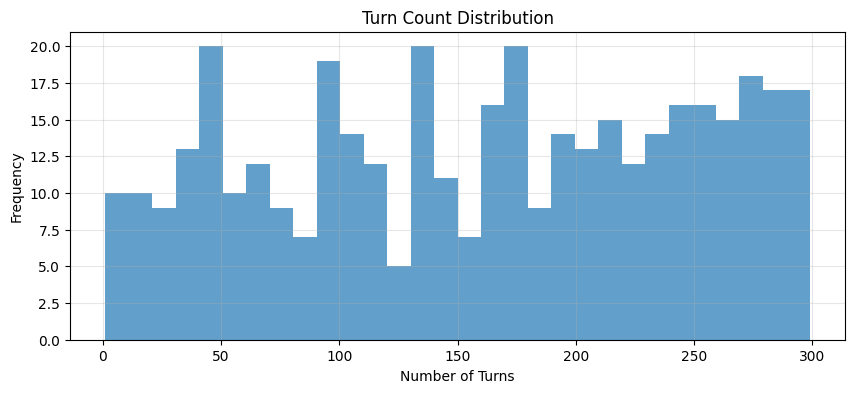

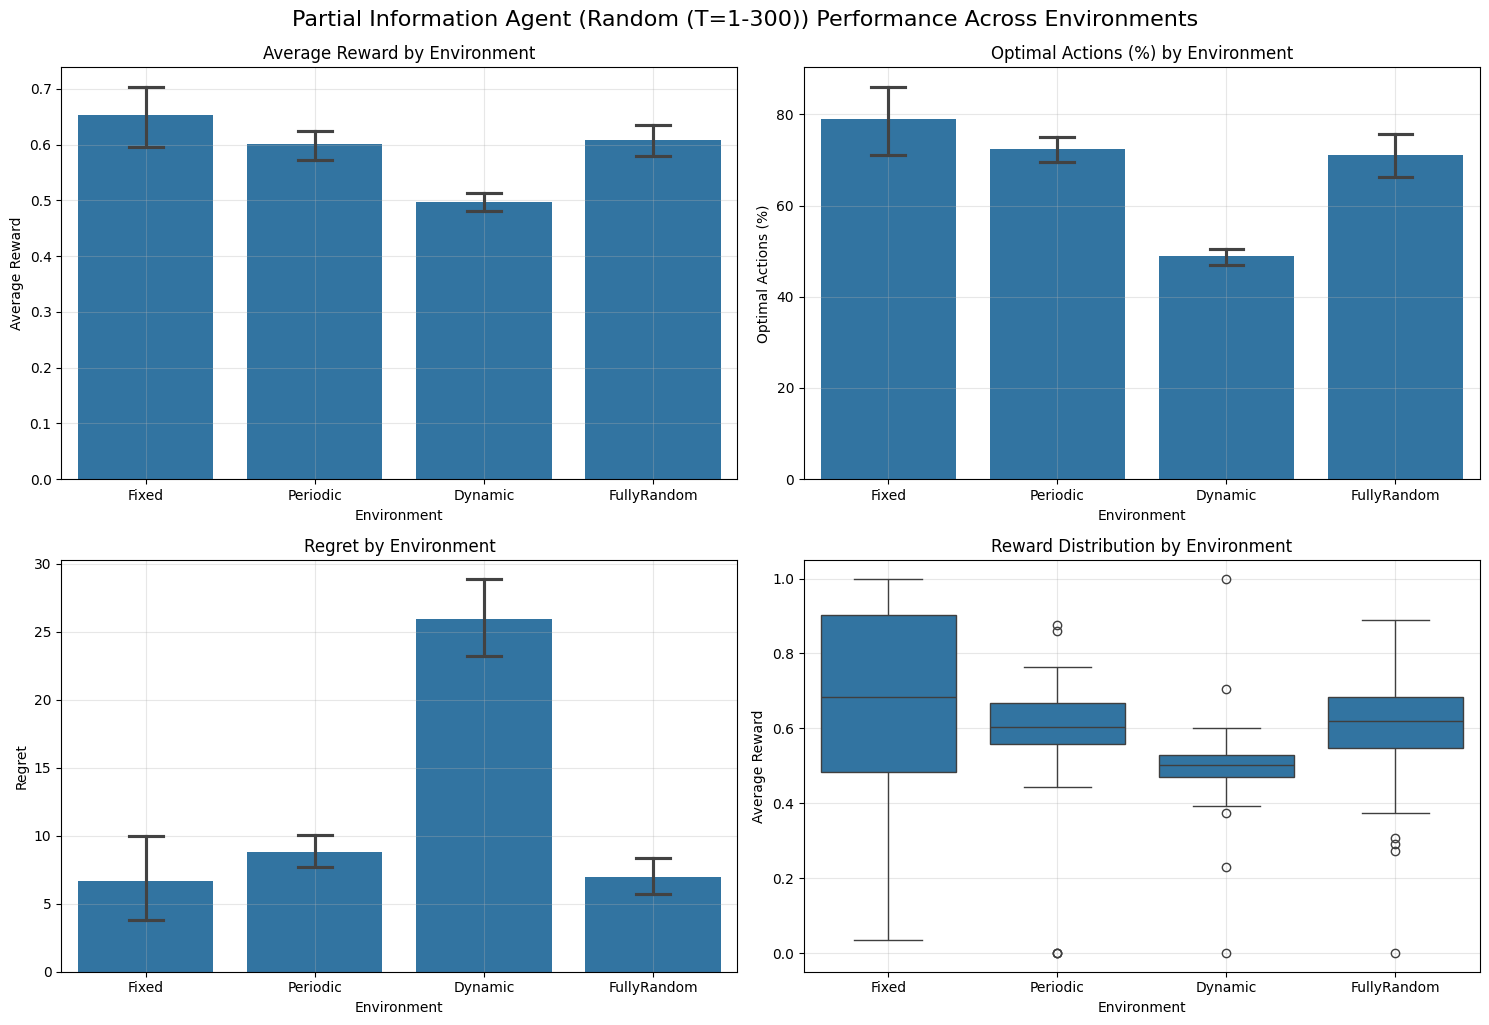

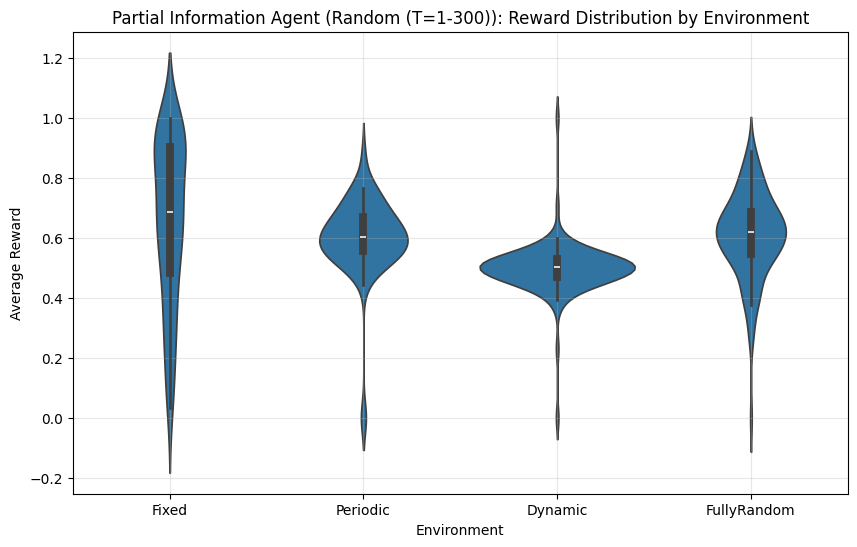

In [ ]:
partial_info_results = evaluate_partial_information_agent(fixed_turns=False)


## Reward Only

In [ ]:
import numpy as np
from typing import Dict

def reward_only_agent(env_info: Dict) -> int:
    """
    Agent that follows a UCB-based exploration-exploitation strategy without knowing T.

    Args:
        env_info (Dict): Dictionary containing:
            - current_turn: Current turn number
            - history: Dictionary with past actions and rewards

    Returns:
        int: The action to take (0 for arm 1, 1 for arm 2)
    """
    current_turn = env_info["current_turn"]
    history = env_info["history"]

    # Fase de exploración: jugar cada brazo una vez al inicio
    if current_turn == 0:
        return 0  # Jugar p1 primero
    elif current_turn == 1:
        return 1  # Jugar p2 después

    # Contar selecciones y calcular media empírica de recompensas
    rewards_p1 = [history["rewards"][i] for i in range(len(history["actions"])) if history["actions"][i] == 0]
    rewards_p2 = [history["rewards"][i] for i in range(len(history["actions"])) if history["actions"][i] == 1]

    N1 = len(rewards_p1)  # Veces que hemos jugado p1
    N2 = len(rewards_p2)  # Veces que hemos jugado p2

    # Calcular medias empíricas
    mean_p1 = np.mean(rewards_p1) if N1 > 0 else 0
    mean_p2 = np.mean(rewards_p2) if N2 > 0 else 0

    # Calcular UCB para cada brazo
    UCB_p1 = mean_p1 + np.sqrt((2 * np.log(current_turn + 1)) / N1) if N1 > 0 else float('inf')
    UCB_p2 = mean_p2 + np.sqrt((2 * np.log(current_turn + 1)) / N2) if N2 > 0 else float('inf')

    # Seleccionar el brazo con el mayor UCB
    return 0 if UCB_p1 > UCB_p2 else 1



===== EVALUATING REWARD-ONLY AGENT WITH Fixed (T=100) TURNS =====

Testing on Fixed environment...

=== RUNNING WITH FIXED TURNS (T=100) ===
FIXED TURNS MODE: Using T=100 for all games


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Fixed, Turn count: 100
Game 20, Environment: Fixed, Turn count: 100
Game 40, Environment: Fixed, Turn count: 100
Game 60, Environment: Fixed, Turn count: 100
Game 80, Environment: Fixed, Turn count: 100

Testing on Periodic environment...

=== RUNNING WITH FIXED TURNS (T=100) ===
FIXED TURNS MODE: Using T=100 for all games


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Periodic, Turn count: 100
Game 20, Environment: Periodic, Turn count: 100
Game 40, Environment: Periodic, Turn count: 100
Game 60, Environment: Periodic, Turn count: 100
Game 80, Environment: Periodic, Turn count: 100

Testing on Dynamic environment...

=== RUNNING WITH FIXED TURNS (T=100) ===
FIXED TURNS MODE: Using T=100 for all games


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Dynamic, Turn count: 100
Game 20, Environment: Dynamic, Turn count: 100
Game 40, Environment: Dynamic, Turn count: 100
Game 60, Environment: Dynamic, Turn count: 100
Game 80, Environment: Dynamic, Turn count: 100

Testing on FullyRandom environment...

=== RUNNING WITH FIXED TURNS (T=100) ===
FIXED TURNS MODE: Using T=100 for all games


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: FullyRandom, Turn count: 100
Game 20, Environment: FullyRandom, Turn count: 100
Game 40, Environment: FullyRandom, Turn count: 100
Game 60, Environment: FullyRandom, Turn count: 100
Game 80, Environment: FullyRandom, Turn count: 100

===== REWARD-ONLY AGENT SUMMARY (Fixed (T=100) TURNS) =====

===== Reward-Only Agent (Fixed (T=100)) Summary Statistics =====

             Average Reward_mean  Average Reward_std  Average Reward_min  \
Environment                                                                
Dynamic                    0.504               0.052                0.39   
Fixed                      0.507               0.202                0.06   
FullyRandom                0.503               0.126                0.16   
Periodic                   0.501               0.078                0.35   

             Average Reward_max  Optimal Actions (%)_mean  \
Environment                                                 
Dynamic                    0.60        

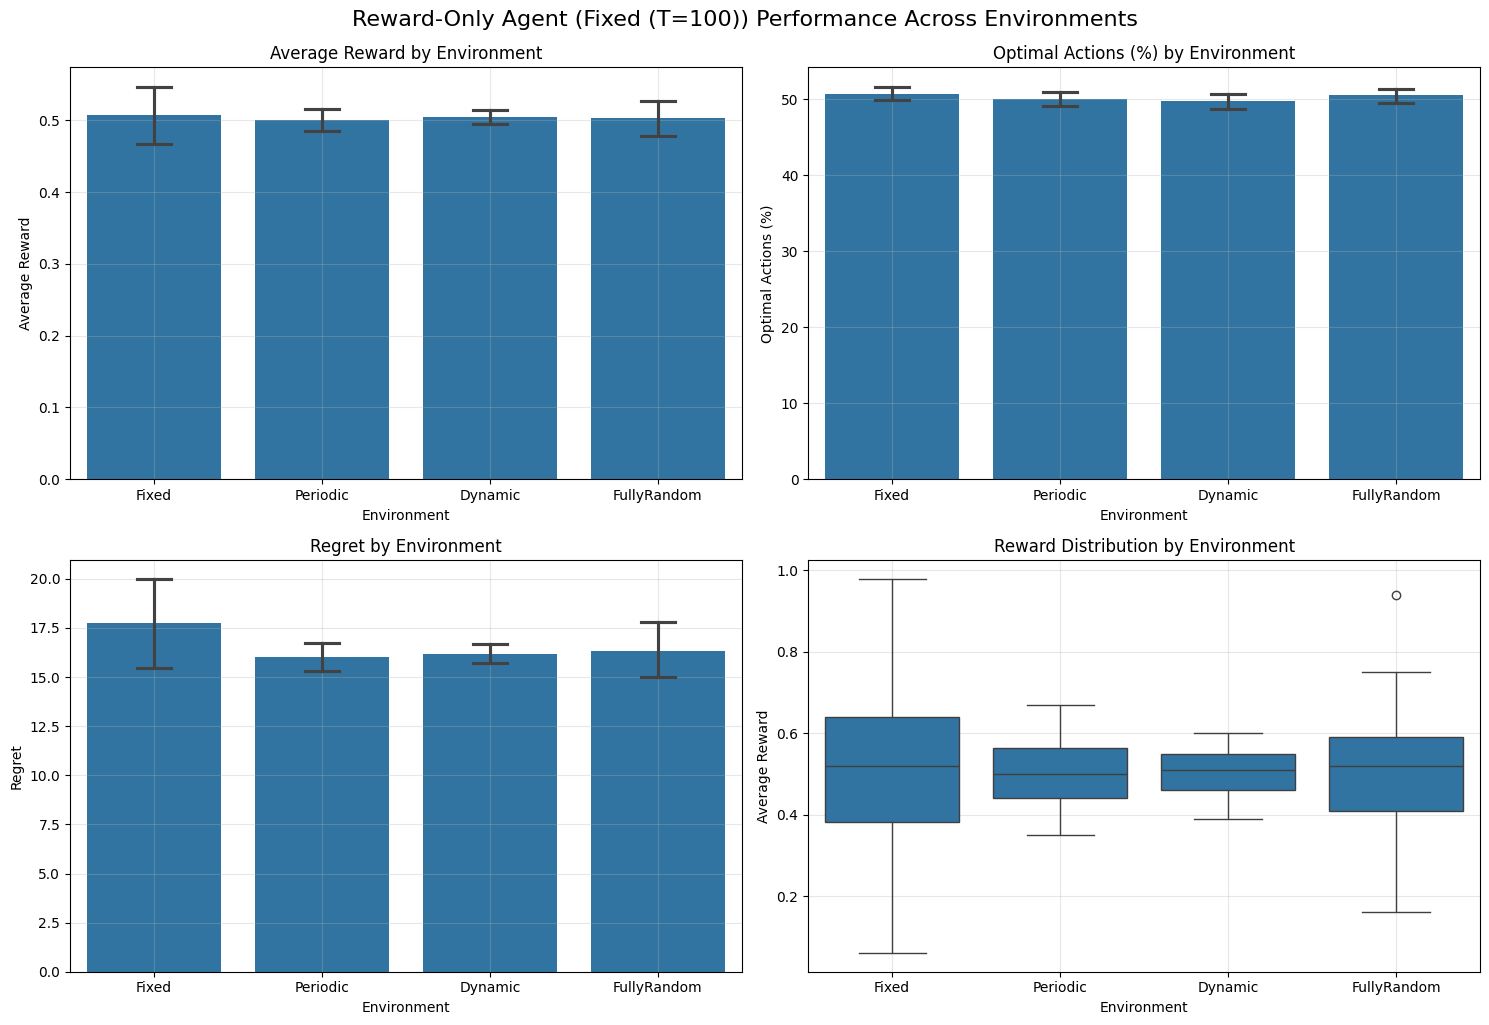

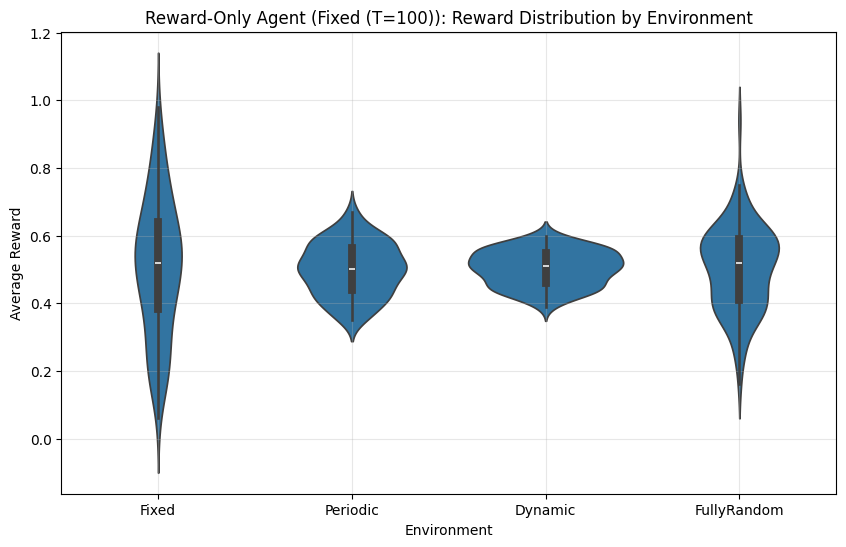

In [ ]:
reward_only_results = evaluate_reward_only_agent()


===== EVALUATING REWARD-ONLY AGENT WITH Random (T=1-300) TURNS =====

Testing on Fixed environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [120, 155, 47, 250, 153]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [120, 155, 47, 250, 153]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Fixed, Turn count: 114
Game 20, Environment: Fixed, Turn count: 9
Game 40, Environment: Fixed, Turn count: 226
Game 60, Environment: Fixed, Turn count: 96
Game 80, Environment: Fixed, Turn count: 232

Turn count summary: Min=2, Max=299, Mean=150.22

Testing on Periodic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [146, 179, 260, 143, 288]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [146, 179, 260, 143, 288]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Periodic, Turn count: 178
Game 20, Environment: Periodic, Turn count: 227
Game 40, Environment: Periodic, Turn count: 112
Game 60, Environment: Periodic, Turn count: 16
Game 80, Environment: Periodic, Turn count: 239

Turn count summary: Min=2, Max=295, Mean=139.22

Testing on Dynamic environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [73, 218, 23, 258, 83]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [73, 218, 23, 258, 83]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: Dynamic, Turn count: 144
Game 20, Environment: Dynamic, Turn count: 3
Game 40, Environment: Dynamic, Turn count: 113
Game 60, Environment: Dynamic, Turn count: 159
Game 80, Environment: Dynamic, Turn count: 29

Turn count summary: Min=3, Max=299, Mean=150.65

Testing on FullyRandom environment...

=== RUNNING WITH RANDOM TURNS (T=1-300) ===
Sample random turn values: [171, 29, 40, 271, 109]
RANDOM TURNS MODE: Will use different turn counts between 1-300 for each game
Sample turn counts: [171, 29, 40, 271, 109]


  0%|          | 0/100 [00:00<?, ?it/s]

Game 0, Environment: FullyRandom, Turn count: 51
Game 20, Environment: FullyRandom, Turn count: 212
Game 40, Environment: FullyRandom, Turn count: 161
Game 60, Environment: FullyRandom, Turn count: 94
Game 80, Environment: FullyRandom, Turn count: 277

Turn count summary: Min=6, Max=300, Mean=155.93

===== REWARD-ONLY AGENT SUMMARY (Random (T=1-300) TURNS) =====

===== Reward-Only Agent (Random (T=1-300)) Summary Statistics =====

             Average Reward_mean  Average Reward_std  Average Reward_min  \
Environment                                                                
Dynamic                    0.488               0.070               0.182   
Fixed                      0.532               0.233               0.062   
FullyRandom                0.497               0.136               0.081   
Periodic                   0.493               0.121               0.000   

             Average Reward_max  Optimal Actions (%)_mean  \
Environment                                    

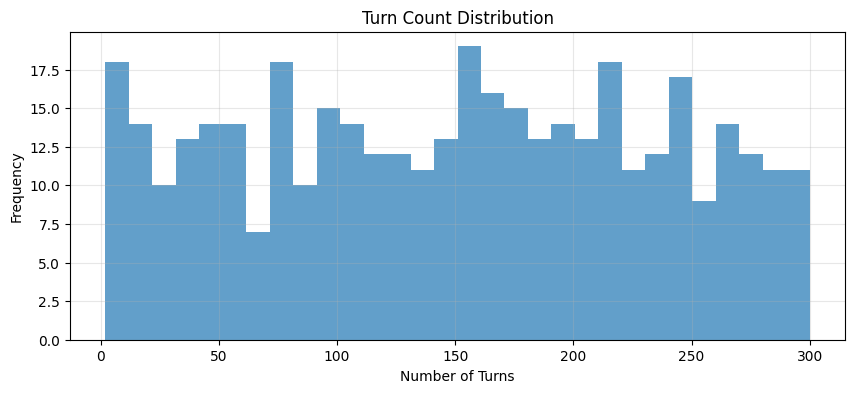

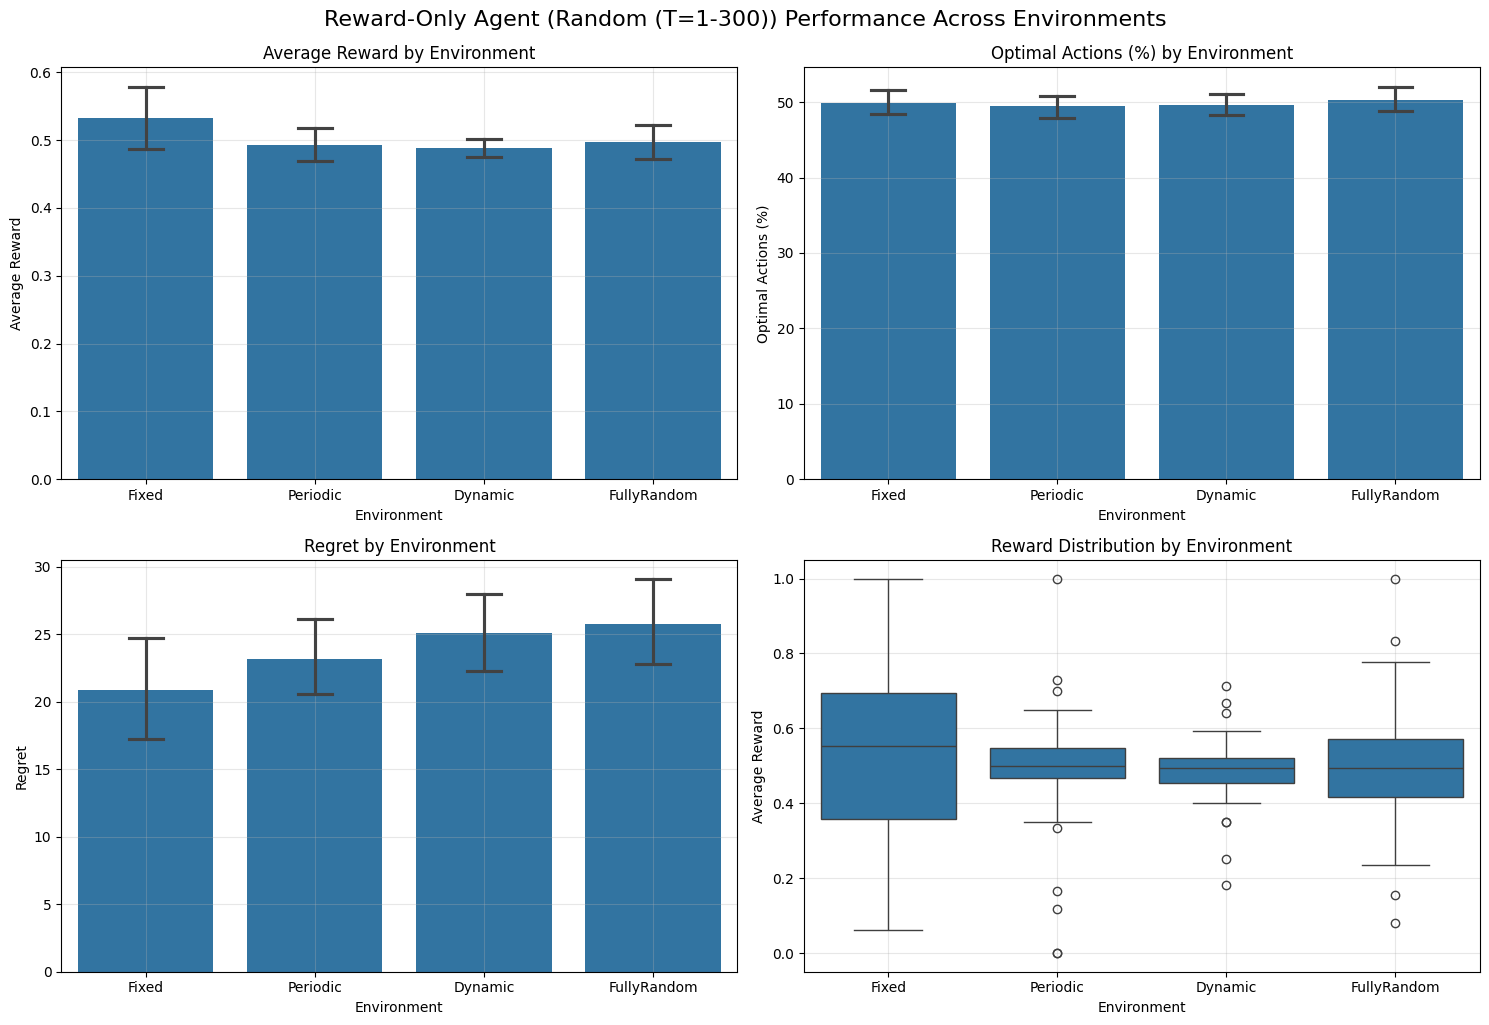

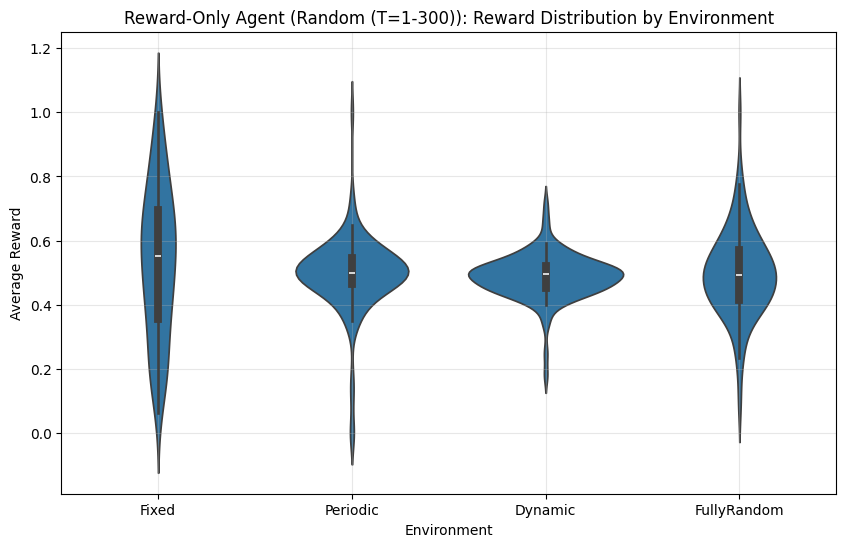

In [ ]:
reward_only_results = evaluate_reward_only_agent(fixed_turns=False)
